# Topic Model Analysis

Todo: 1. industry : cusip to naics mapping 2. Topic evloution

In [44]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

from compute_topic import *
from manage_path import *
from topic_model_analysis import *

import plotly
plotly.offline.init_notebook_mode(connected=True) 
import plotly.graph_objs as go
import plotly.io as pio
from itertools import repeat

import multiprocessing
from collections import deque

import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict

## Topic Evolution
1. Dc_v1: 1 document for buy and sell, per dealer, per day.
2. Dc_v2: 1 document for buy and 1 document for sell, per dealer, per day.
3. Dc_v3: Either DC_v1 or DC_v2 without the 2 (4) documents representing the Source_seller and Source_buyer.
4. Tc_v1: 1 document for (buyer,seller,year)

In [151]:
result_directory = get_result_directory()
topic = pd.read_csv(result_directory/'Dc_v2_250topics.csv',index_col=0)

In [143]:
topic.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
"0,2014-01-01,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.502,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"0,2014-01-02,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.176914,NaN,NaN,NaN,NaN,NaN,NaN
"0,2014-01-03,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.102419,NaN,NaN,NaN,NaN,NaN,NaN
"0,2014-01-06,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"0,2014-01-07,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
def get_document_item(document,position):
    return str(document).split(',')[position]

In [145]:
get_document_item_vectorize = np.vectorize(get_document_item)

In [154]:
topic['dealer'] = pd.Series(list(zip(get_document_item_vectorize(topic.index,0),get_document_item_vectorize(topic.index,1)))).values

In [152]:
pd.Series(list(zip(get_document_item_vectorize(topic.index,0),get_document_item_vectorize(topic.index,1))))

0             (0, 2014-01-01)
1             (0, 2014-01-02)
2             (0, 2014-01-03)
3             (0, 2014-01-06)
4             (0, 2014-01-07)
5             (0, 2014-01-08)
6             (0, 2014-01-09)
7             (0, 2014-01-10)
8             (0, 2014-01-13)
9             (0, 2014-01-14)
10            (0, 2014-01-15)
11            (0, 2014-01-16)
12            (0, 2014-01-17)
13            (0, 2014-01-20)
14            (0, 2014-01-21)
15            (0, 2014-01-22)
16            (0, 2014-01-23)
17            (0, 2014-01-24)
18            (0, 2014-01-27)
19            (0, 2014-01-28)
20            (0, 2014-01-29)
21            (0, 2014-01-30)
22            (0, 2014-01-31)
23            (0, 2014-02-02)
24            (0, 2014-02-03)
25            (0, 2014-02-04)
26            (0, 2014-02-05)
27            (0, 2014-02-06)
28            (0, 2014-02-07)
29            (0, 2014-02-09)
                 ...         
196421    (99999, 2014-11-24)
196422    (99999, 2014-11-25)
196423    

In [147]:
topic.index = pd.to_datetime(get_document_item_vectorize(topic.index,1))

In [148]:
topic.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,dealer
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.502,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.176914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.102419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
count_matrix = topic.groupby(["dealer"]).count()

In [9]:
topic.describe()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
count,966.000000,436.000000,751.000000,368.000000,534.000000,1713.000000,144.000000,1567.000000,1001.000000,506.000000,...,988.000000,611.000000,410.000000,632.000000,401.000000,641.000000,539.000000,183.000000,922.000000,742.000000
mean,0.292779,0.332736,0.310922,0.335785,0.304158,0.347855,0.315025,0.300752,0.342264,0.375212,...,0.337672,0.308977,0.352651,0.294315,0.296049,0.328182,0.346033,0.310650,0.330181,0.307890
std,0.176539,0.208902,0.190468,0.195945,0.180112,0.204520,0.199633,0.187705,0.198124,0.230252,...,0.198415,0.189909,0.163064,0.186423,0.184763,0.194131,0.199031,0.190417,0.201678,0.186158
min,0.100444,0.100464,0.100717,0.100385,0.100018,0.100200,0.100495,0.100141,0.100169,0.100748,...,0.100400,0.100216,0.100061,0.100248,0.100159,0.100200,0.100400,0.100980,0.100115,0.100294
25%,0.159304,0.160486,0.165785,0.173176,0.162147,0.182182,0.144453,0.157904,0.182182,0.175009,...,0.175379,0.165581,0.217816,0.149599,0.153037,0.175974,0.181849,0.167134,0.171319,0.165880
50%,0.234391,0.266078,0.247073,0.280969,0.250500,0.286160,0.251000,0.241378,0.286072,0.298403,...,0.285396,0.248742,0.355153,0.223892,0.227986,0.253102,0.286286,0.246850,0.264961,0.250353
75%,0.366196,0.500666,0.400800,0.458755,0.400800,0.500859,0.448390,0.391686,0.478810,0.588955,...,0.431591,0.400800,0.461100,0.398996,0.401794,0.447955,0.501153,0.415885,0.409699,0.400800
max,0.917000,0.935613,0.954606,0.941412,0.909455,0.960160,0.911634,0.978808,0.975743,0.963111,...,0.968601,0.937750,0.971543,0.963709,0.945794,0.952571,0.978808,0.984909,0.993447,0.875500


In [92]:
def get_dealer_by_ID(matrix,dealer_id,matrix_name):
    result = matrix.loc[matrix['dealer'] == dealer_id].copy().drop(labels='dealer',axis=1)
    return (result,dealer_id,matrix_name)

def topicXtime(dealer_data):
    dealer_data,dealer_id,matrix_name = dealer_data[0],dealer_data[1],dealer_data[2]
    
    heatmap_data = [
        go.Heatmap(
            z=dealer_data.values.tolist(),
            zmin=0,
            zmax=1,
            x=dealer_data.columns,
            y=dealer_data.index,
            colorscale='Jet',
        )
    ]

    layout = go.Layout(
        title='{} Dealer {}: Topic-Time'.format(matrix_name,dealer_id),
        #xaxis = dict(ticks='', nticks=36),
        #yaxis = dict(ticks='' )
    )
    
    fig = go.Figure(data=heatmap_data, layout=layout)
    #plotly.offline.iplot(fig, filename='topicXtime-heatmap')

    image_directory = get_image_directory() / '{}'.format(matrix_name)
    if not image_directory.is_dir():
        create_directory(image_directory)
    file_path = image_directory / '{}_dealer{}_topic_time.svg'.format(matrix_name,dealer_id)
    pio.write_image(fig, str(file_path))

In [97]:
dealer_df_list = list(map(lambda x: get_dealer_by_ID(topic,x,"Dc_v1"),list(topic['dealer'].unique()[0:100])))
len(dealer_df_list)

100

In [98]:
deque(map(topicXtime,dealer_df_list))

deque([None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,
       None,

In [101]:
pio.orca.config

orca configuration
------------------
    executable: orca
    port: None
    timeout: None
    default_width: None
    default_height: None
    default_scale: 1
    default_format: png
    mathjax: https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js
    topojson: None
    mapbox_access_token: None

constants
---------
    plotlyjs: C:\Users\raymo\Anaconda3\envs\topicModeling\lib\site-packages\plotly\package_data\plotly.min.js 
    config_file: C:\Users\raymo\.plotly\.orca


In [102]:
plotly.io.orca.status

orca status
-----------
    state: running
    executable: C:\Users\raymo\Anaconda3\envs\topicModeling\orca.CMD
    version: 1.2.1
    port: 50285
    pid: 8456
    command: ['C:\\Users\\raymo\\Anaconda3\\envs\\topicModeling\\orca.CMD', 'serve', '-p', '50285', '--plotly', 'C:\\Users\\raymo\\Anaconda3\\envs\\topicModeling\\lib\\site-packages\\plotly\\package_data\\plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']
    

In [91]:
cpu_cores = multiprocessing.cpu_count() - 1
pool = multiprocessing.Pool(cpu_cores)
#pool.starmap(topicXtime,dealer_df_list)
pool.close()

### Try Seaborn

In [48]:
sns.set()

In [49]:
month_list = list(OrderedDict.fromkeys(dealer_df_list[0][0].index.strftime('%Y-%m')))

Text(0.5, 1.0, 'test')

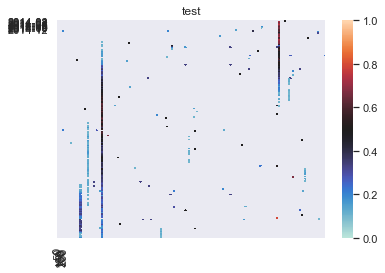

In [85]:
ax = sns.heatmap(dealer_df_list[0][0],vmin=0,vmax=1,center=0.5,xticklabels=[0,50,100,150,200,250],yticklabels=month_list)

num_x_ticks = 5
# the index of the position of yticks
xticks = np.linspace(0, len(dealer_df_list[0][0].columns) - 1, num_x_ticks, dtype=np.int)

num_y_ticks = len(month_list)
# the index of the position of yticks
yticks = np.linspace(0, len(dealer_df_list[0][0].index) - 1, num_y_ticks, dtype=np.int)

#ax.set_xticks(xticks)
#ax.set_yticks(yticks)
ax.set_autoscaley_on(True)
ax.set_title('test')

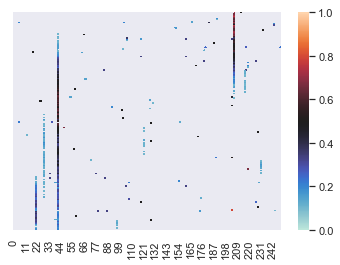

In [90]:
import matplotlib.dates as mdates
ax = sns.heatmap(dealer_df_list[0][0],vmin=0,vmax=1,center=0.5)

ax.yaxis.set_major_locator(mdates.MonthLocator())
ax.yaxis.set_minor_locator(mdates.DayLocator())
#ax.yaxis.set_major_formatter(mdates.DateFormatter('%b'))
figure = ax.get_figure()
figure.savefig('test.png', dpi=400)

In [83]:
yticks

array([  0,  26,  52,  78, 104, 130, 156, 182, 208, 234, 260, 287])

In [82]:
xticks

array([  0,  62, 124, 186, 249])

In [68]:
figure = ax.get_figure()
figure.savefig('test.png', dpi=400)
#figure.savefig('test.svg', format="svg")

In [64]:
ax.fig.autofmt_ydate()

AttributeError: 'AxesSubplot' object has no attribute 'fig'

In [ ]:
topic.corr().head()

## Topic Terms Distribution
Below is the topic terms ditrutbution demo. Since we already got Document X Topics, we want to have a Topic X Terms too.

In [ ]:
model = load_model('Tc_v1',250)

In [ ]:
topic_terms_distribution = pd.DataFrame(model.get_topics())

In [ ]:
topic_terms_distribution.head()

## Industy Analysis

In [ ]:
data_path = get_pickle_directory() / 'TRACE2014_jinming.pkl'
data = pd.read_pickle(data_path)

In [ ]:
data.columns

In [ ]:
print("We have {} rows of data".format(data.shape[0]))

In [ ]:
def fix_NAICS_Code(NAICS_Code):
    "Fix the problem that FISD omits 0 if NAICS_Code ends with 0"
    if len(str(NAICS_Code))==5:
        NAICS_Code = NAICS_Code+'0'
    return NAICS_Code
fix_NAICS_Code_vectorize = np.vectorize(fix_NAICS_Code)
data['NAICS_CODE'] = fix_NAICS_Code_vectorize(data['NAICS_CODE'].values)

In [ ]:
data = data[['BOND_SYM_ID', 'INDUSTRY_GROUP', 'INDUSTRY_CODE', 'PARENT_ID', 'NAICS_CODE','SIC_CODE']].copy()

In [ ]:
data['INDUSTRY_CODE'].value_counts().plot.pie()

In [ ]:
# Get the NAICS_code lookup table
NAICS_code_path = get_dataset_directory() / 'NAICS_Code_Lookup.csv'
NAICS_code = pd.read_csv(NAICS_code_path,dtype={'Code':str,'Description':str})

In [ ]:
# Group by BOND_SYM_ID and NAICS_CODE of 
NAICS_CODE_count = data['NAICS_CODE'].value_counts()
# Series to DataFrame
NAICS_CODE_count = NAICS_CODE_count.to_frame(name='count')

In [ ]:
NAICS_code_total = NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)
NAICS_code_total['percentage'] = NAICS_code_total['count']/data.shape[0]

In [ ]:
NAICS_code_total.head()

In [ ]:
(NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)['count']/data.shape[0]).sum()

In [ ]:
data.groupby(by=['NAICS_CODE'])['BOND_SYM_ID'].nunique().sort_values(ascending=False).head()

In [ ]:
data.groupby(by=['BOND_SYM_ID'])

In [ ]:
Bond_X_Industry = data.drop_duplicates(['BOND_SYM_ID'])

In [ ]:
Bond_X_Industry.sort_values(by=['BOND_SYM_ID']).head()

## Convergence Test

In [ ]:
import re
import matplotlib.pyplot as plt
def convergence_likelyhood(model_name,num_topics):
    p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
    matches = [p.findall(l) for l in open('../LDAModel/{}_{}topics.log.txt'.format(model_name,num_topics))]
    matches = [m for m in matches if len(m) > 0]
    tuples = [t[0] for t in matches]
    perplexity = [float(t[1]) for t in tuples]
    liklihood = [float(t[0]) for t in tuples]
    iter = list(range(0,len(tuples)*10,10))
    plt.plot(iter,liklihood,c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("iteration")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.savefig("{}_{}topics.pdf".format(model_name,num_topics))
    plt.close()

In [ ]:
#convergence_likelyhood("matrix_1",250)